<a href="https://colab.research.google.com/github/Am5678/multimodal-Crime-video-analysis/blob/main/crime_audio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
import librosa.display
import os
from scipy.io import wavfile
import mutagen
import mutagen.mp3
from google.colab import files, drive
from tqdm import tqdm
import shutil
import random
from pydub import AudioSegment

%matplotlib inline

In [2]:
!pip install mutagen
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.6 MB/s eta 0:00:00


In [4]:
%matplotlib inline

# Upload dataset folder directly from file manager
from google.colab import files
import os

print("Select and upload your burglary_voice folder (select all MP3 files):")
uploaded = files.upload()

Select and upload your burglary_voice folder (select all MP3 files):


Saving clip1.mp3 to clip1.mp3
Saving clip2.mp3 to clip2.mp3
Saving clip3.mp3 to clip3.mp3
Saving clip4.mp3 to clip4.mp3
Saving clip5.mp3 to clip5.mp3
Saving clip6.mp3 to clip6.mp3
Saving clip7.mp3 to clip7.mp3
Saving clip8.mp3 to clip8.mp3
Saving clip9.mp3 to clip9.mp3
Saving clip10.mp3 to clip10.mp3
Saving sec1_4_5_7_11.mp3 to sec1_4_5_7_11.mp3
Saving sec1_10.mp3 to sec1_10.mp3
Saving sec2_7_18.mp3 to sec2_7_18.mp3
Saving sec2_20.mp3 to sec2_20.mp3
Saving sec3_7.mp3 to sec3_7.mp3
Saving sec4.mp3 to sec4.mp3


In [5]:
# Create dataset directory and move uploaded files
dataset_path = '/content/burglary_voice'
os.makedirs(dataset_path, exist_ok=True)

In [6]:
for filename in uploaded.keys():
    if filename.lower().endswith('.mp3'):
        # Move file to dataset directory
        os.rename(filename, os.path.join(dataset_path, filename))
        print(f"Moved {filename} to dataset directory")

print(f"Dataset ready at: {dataset_path}")

Moved clip1.mp3 to dataset directory
Moved clip2.mp3 to dataset directory
Moved clip3.mp3 to dataset directory
Moved clip4.mp3 to dataset directory
Moved clip5.mp3 to dataset directory
Moved clip6.mp3 to dataset directory
Moved clip7.mp3 to dataset directory
Moved clip8.mp3 to dataset directory
Moved clip9.mp3 to dataset directory
Moved clip10.mp3 to dataset directory
Moved sec1_4_5_7_11.mp3 to dataset directory
Moved sec1_10.mp3 to dataset directory
Moved sec2_7_18.mp3 to dataset directory
Moved sec2_20.mp3 to dataset directory
Moved sec3_7.mp3 to dataset directory
Moved sec4.mp3 to dataset directory
Dataset ready at: /content/burglary_voice


In [8]:
def create_metadata_from_mp3_files(dataset_path):
    """Create metadata CSV from MP3 files in the dataset folder"""
    audio_files = []
    classes = []
    durations = []
    sample_rates = []

    # Get all MP3 files
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith('.mp3'):
                file_path = os.path.join(root, file)

                # Extract class from folder name or filename
                # Assuming folder structure: burglary_voice/class_name/file.mp3
                # Or filename format: class_name_xxx.mp3
                if len(root.split('/')) > 1:
                    class_name = os.path.basename(root)
                else:
                    # Extract from filename
                    class_name = file.split('_')[0] if '_' in file else 'unknown'

                try:
                    # Get audio metadata
                    audio = AudioSegment.from_mp3(file_path)
                    duration = len(audio) / 1000.0  # Duration in seconds
                    sample_rate = audio.frame_rate

                    audio_files.append(file)
                    classes.append(class_name)
                    durations.append(duration)
                    sample_rates.append(sample_rate)

                except Exception as e:
                    print(f"Error processing {file}: {e}")
                    continue

    # Create DataFrame
    metadata_df = pd.DataFrame({
        'slice_file_name': audio_files,
        'class': classes,
        'duration': durations,
        'sample_rate': sample_rates
    })

    return metadata_df

In [9]:
print("Creating metadata from MP3 files...")
metadata = create_metadata_from_mp3_files(dataset_path)
metadata.to_csv('data.csv', index=False)
print(f"Created metadata for {len(metadata)} audio files")

# Display metadata
metadata.head()

Creating metadata from MP3 files...
Created metadata for 16 audio files


,slice_file_name,class,duration,sample_rate
0,clip9.mp3,burglary_voice,10.017,44100
1,clip7.mp3,burglary_voice,10.001,44100
2,clip1.mp3,burglary_voice,10.002,44100
3,sec3_7.mp3,burglary_voice,11.099,44100
4,sec4.mp3,burglary_voice,32.067,44100


In [10]:
class_distr = metadata['class'].value_counts()
print("Class distribution:")
print(class_distr)

Class distribution:
class
burglary_voice    16
Name: count, dtype: int64


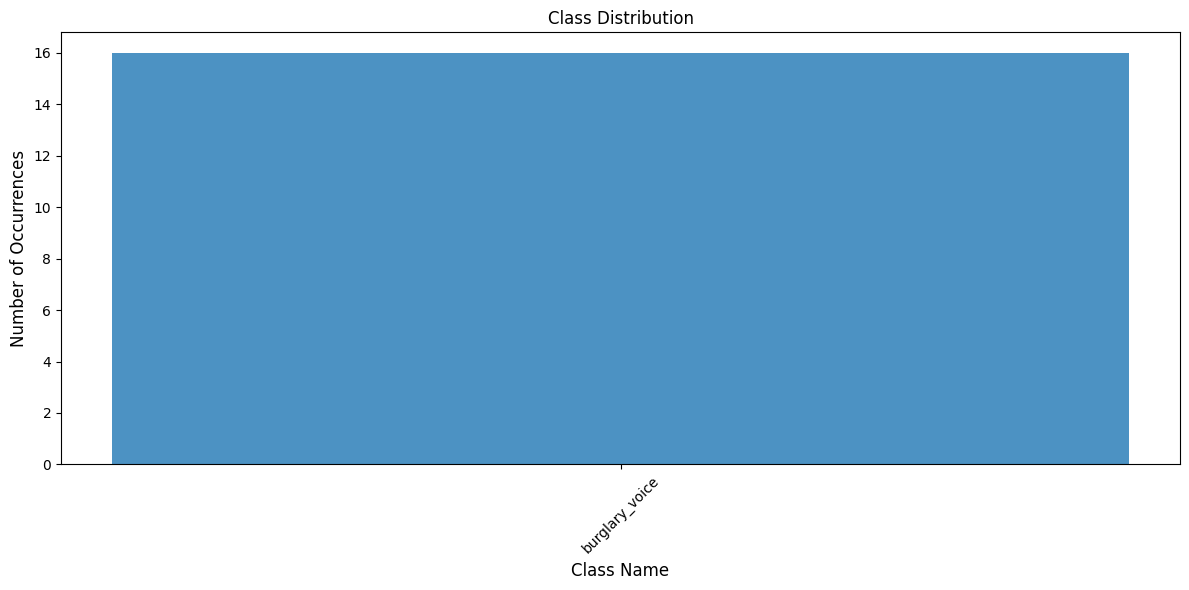

In [30]:
# Plot class distributions
plt.figure(figsize=(12, 6))
plt.bar(class_distr.index, class_distr.values, alpha=0.8)
plt.title('Class Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class Name', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Check for missing values
missing_values = metadata.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
slice_file_name    0
class              0
duration           0
sample_rate        0
dtype: int64


In [15]:
def get_audio_metadata_mp3(filepath):
    #"\"\"Get metadata from MP3 file\"\"\"
    metadata_dict = {}
    try:
        # Using pydub for MP3
        audio = AudioSegment.from_mp3(filepath)
        metadata_dict['length'] = len(audio) / 1000.0  # Convert to seconds
        metadata_dict['sample_rate'] = audio.frame_rate
        metadata_dict['channels'] = audio.channels
        metadata_dict['bitrate'] = None  # Not directly available in pydub
        metadata_dict['bits_per_sample'] = audio.sample_width * 8

    except Exception as e:
        print(f"Error getting metadata for {filepath}: {e}")
        metadata_dict = {'length': 0, 'sample_rate': 22050, 'channels': 1, 'bitrate': 0, 'bits_per_sample': 16}

    return metadata_dict

# Function to create complete dataset DataFrame
def create_complete_dataset_df(metadata_df, dataset_path):
    #"\"\"Create complete dataset DataFrame with file paths\"\"\"
    filepaths = []
    for i, row in metadata_df.iterrows():
        # Find the actual file path
        found = False
        for root, dirs, files in os.walk(dataset_path):
            if row['slice_file_name'] in files:
                filepaths.append(os.path.join(root, row['slice_file_name']))
                found = True
                break
        if not found:
            filepaths.append(None)

    metadata_df['filepath'] = filepaths
    return metadata_df

# Create complete dataset
metadata_df = create_complete_dataset_df(metadata, dataset_path)


In [16]:

# Remove rows with missing filepaths
metadata_df = metadata_df.dropna(subset=['filepath'])
print(f"Dataset contains {len(metadata_df)} valid audio files")


Dataset contains 16 valid audio files


In [18]:
# Enhanced MFCC feature extraction for MP3
def features_extractor_mp3(file_path):
    #"\"\"Extract MFCC features from MP3 file\"\"\"
    try:
        # Load MP3 file using librosa (handles MP3 automatically)
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', sr=22050)

        # Apply preprocessing
        audio_filtered = librosa.effects.preemphasis(audio, coef=0.95)

        # Extract MFCC features
        mfccs_features = librosa.feature.mfcc(y=audio_filtered, sr=sample_rate, n_mfcc=40, n_fft=1024)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

        # Normalize features
        mfccs_scaled_features = (mfccs_scaled_features - np.mean(mfccs_scaled_features)) / np.std(mfccs_scaled_features)

        return mfccs_scaled_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(40)  # Return zero vector if processing fails

# Extract features from all MP3 files
print("Extracting MFCC features from MP3 files...")
extracted_features = []

for index_num, row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
    file_path = row['filepath']
    final_class_labels = row['class']

    if file_path and os.path.exists(file_path):
        data = features_extractor_mp3(file_path)
        extracted_features.append([data, final_class_labels])
    else:
        print(f"File not found: {file_path}")

# Convert to DataFrame
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
print(f"Extracted features from {len(extracted_features_df)} files")


Extracting MFCC features from MP3 files...


 31%|███▏      | 5/16 [00:14<00:24,  2.18s/it]

Error processing /content/burglary_voice/clip9.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/clip7.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/clip1.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/sec3_7.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/c

 56%|█████▋    | 9/16 [00:14<00:07,  1.00s/it]

Error processing /content/burglary_voice/clip8.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/sec1_4_5_7_11.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/sec2_7_18.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/clip2.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-package

 75%|███████▌  | 12/16 [00:14<00:02,  1.52it/s]

Error processing /content/burglary_voice/sec1_10.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/clip6.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/sec2_20.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/clip4.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/libros

100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

Error processing /content/burglary_voice/clip3.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Error processing /content/burglary_voice/clip10.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
Extracted features from 16 files


In [19]:
extracted_features_df.to_csv("extracted_features_burglary.csv", index=False)


In [20]:
# Display feature extraction results
print("Feature extraction completed!")
print("Classes found:", extracted_features_df['class'].unique())
print("Feature shape:", extracted_features_df['feature'].iloc[0].shape if len(extracted_features_df) > 0 else "No features")

# Data preparation for training
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

Feature extraction completed!
Classes found: ['burglary_voice']
Feature shape: (40,)


In [21]:
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Feature matrix shape: (16, 40)
Labels shape: (16,)


In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_encoded = to_categorical(labelencoder.fit_transform(y))

In [23]:
print("Label encoding completed")
print("Classes:", labelencoder.classes_)
print("Encoded shape:", y_encoded.shape)


Label encoding completed
Classes: ['burglary_voice']
Encoded shape: (16, 1)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Model creation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")

num_labels = y_encoded.shape[1]
print(f"Number of classes: {num_labels}")

Training set: (12, 40)
Test set: (4, 40)
TensorFlow version: 2.18.0
Number of classes: 1


In [25]:
# Create neural network model
model = Sequential()

# First layer
model.add(Dense(1600, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Second layer
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Third layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1600)           │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 800)            │     1,280,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 400)            │       320,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,201 (6.36 MB)

 Trainable params: 1,667,201 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.00000, saving model to saved_models/burglary_audio_classification.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: val_loss did not improve from 0.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5: val_loss 

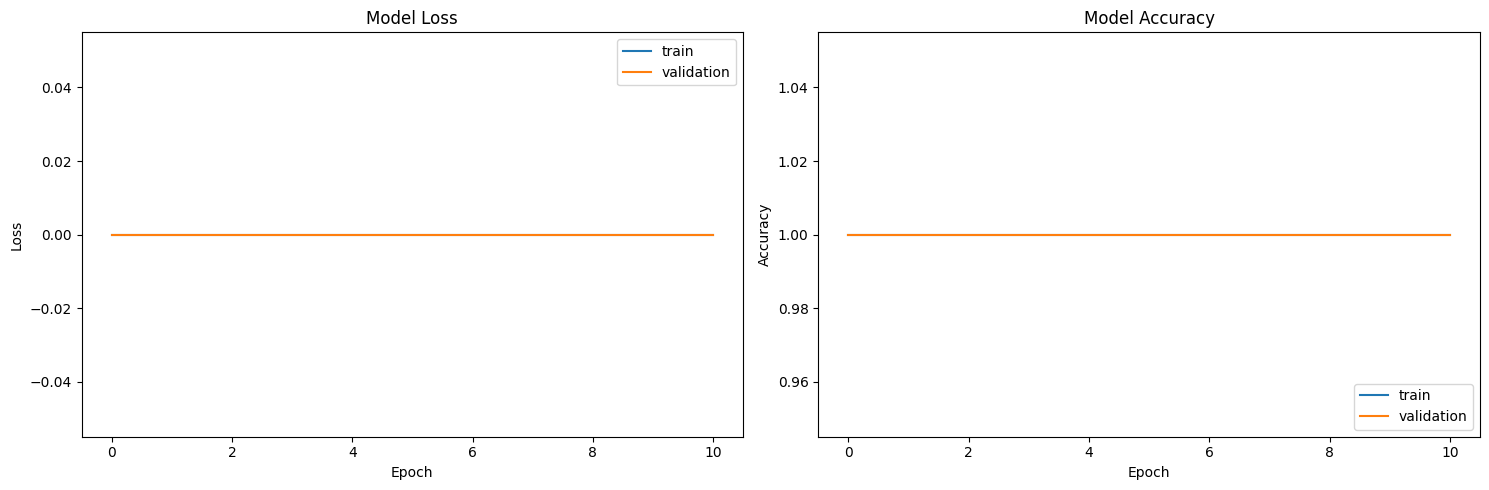

In [26]:
num_epochs = 100
num_batch_size = 32

# Callbacks
os.makedirs('saved_models', exist_ok=True)
checkpointer = ModelCheckpoint(filepath='saved_models/burglary_audio_classification.h5',
                              verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

print("Starting model training...")
start = datetime.now()

# Train model
history = model.fit(X_train, y_train,
                   batch_size=num_batch_size,
                   epochs=num_epochs,
                   validation_data=(X_test, y_test),
                   callbacks=[checkpointer, early_stopping],
                   verbose=1)

duration = datetime.now() - start
print(f"Training completed in time: {duration}")
# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='lower right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (4, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


=== Model Performance ===
Test Accuracy: 1.0000
Test Loss: 0.0000
\nClassification Report:
                precision    recall  f1-score   support

burglary_voice       1.00      1.00      1.00         4

      accuracy                           1.00         4
     macro avg       1.00      1.00      1.00         4
  weighted avg       1.00      1.00      1.00         4



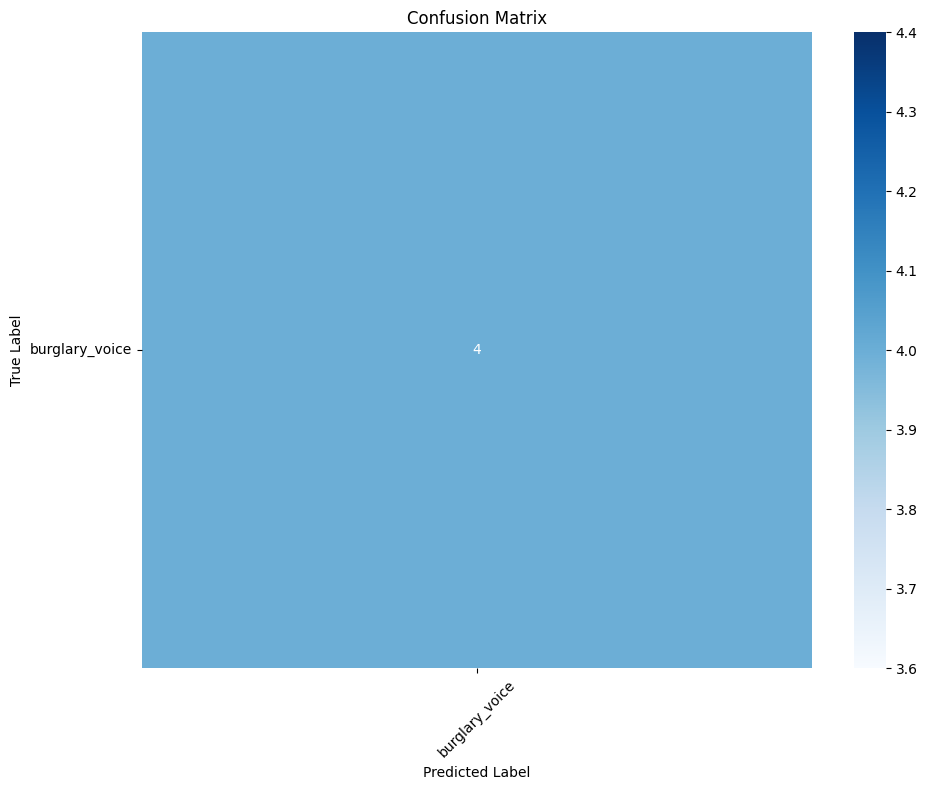

In [27]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
class_report = classification_report(y_true, y_pred, target_names=labelencoder.classes_)

# Model performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print("=== Model Performance ===")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
print("\\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=labelencoder.classes_,
           yticklabels=labelencoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Prediction function for new MP3 files
def predict_class_label_mp3(filename, model, labelencoder):
    #"\"\"Predict class label for a new MP3 file\"\"\"
    try:
        # Extract features
        features = features_extractor_mp3(filename)
        features = features.reshape(1, -1)

        # Predict
        predicted_prob = model.predict(features)
        predicted_label = np.argmax(predicted_prob, axis=-1)
        prediction_class = labelencoder.inverse_transform(predicted_label)
        confidence = np.max(predicted_prob)

        return prediction_class[0], confidence
    except Exception as e:
        print(f"Error predicting for {filename}: {e}")
        return "unknown", 0.0

In [29]:
print("\\n=== Testing Prediction Function ===")
if len(metadata_df) > 0:
    # Test with a random file from the dataset
    test_file = metadata_df.iloc[0]['filepath']
    if os.path.exists(test_file):
        predicted_class, confidence = predict_class_label_mp3(test_file, model, labelencoder)
        actual_class = metadata_df.iloc[0]['class']
        print(f"Test file: {os.path.basename(test_file)}")
        print(f"Actual class: {actual_class}")
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")

# Function to upload and test new MP3 files
def test_new_audio_file():
    #"\"\"Upload and test a new MP3 file\"\"\"
    print("Upload an MP3 file to test:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.lower().endswith('.mp3'):
            predicted_class, confidence = predict_class_label_mp3(filename, model, labelencoder)
            print(f"File: {filename}")
            print(f"Predicted class: {predicted_class}")
            print(f"Confidence: {confidence:.4f}")

            # Display audio waveform
            try:
                audio, sr = librosa.load(filename, sr=22050)
                plt.figure(figsize=(12, 4))
                librosa.display.waveshow(audio, sr=sr)
                plt.title(f'Waveform - Predicted: {predicted_class} (Confidence: {confidence:.4f})')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.show()
            except Exception as e:
                print(f"Could not display waveform: {e}")
        else:
            print(f"Skipping {filename} - not an MP3 file")

\n=== Testing Prediction Function ===
Error processing /content/burglary_voice/clip9.mp3: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /usr/local/lib/python3.11/dist-packages/librosa/core/audio.py, line 33, in <module>

----> resampy = lazy.load("resampy")
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Test file: clip9.mp3
Actual class: burglary_voice
Predicted class: burglary_voice
Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
